In [1]:
from munich_utils import *
from potsdam_utils import map_label2rgb, idx2rgb, idx2label

import torch.nn as nn

import seaborn as sns
import pandas as pd

### DataLoader

In [2]:
# Load config file and get potsdam data path
import yaml
config_path = '/home/tu/tu_tu/tu_zxmav84/DS_Project/modules/config.yml'
with open(config_path, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
path = config['data']['potsdam']

In [3]:
# Initialize DataLoader for munich
BATCH_SIZE = 8
test_loader = get_munich_test_loader(batch_size=BATCH_SIZE)

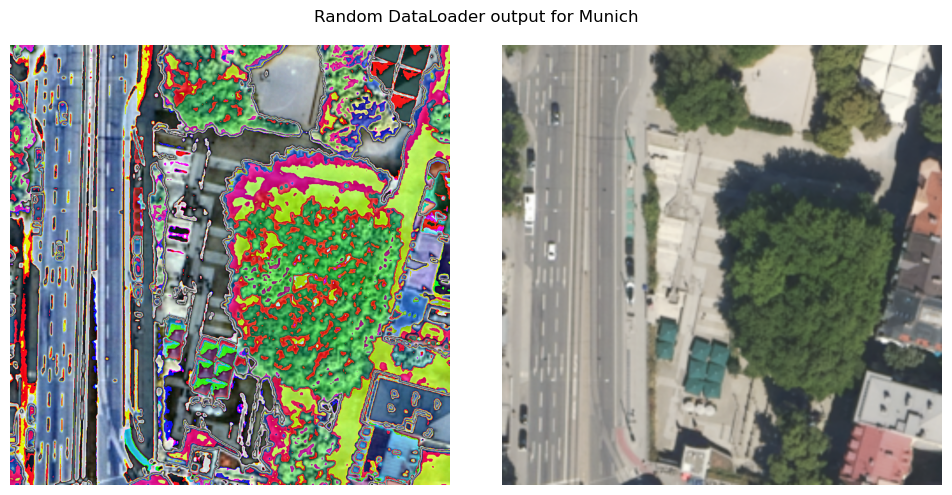

In [4]:
img = next(iter(test_loader))[3,:,:,:]
plot_example(img, "Random DataLoader output for Munich")

### Inference on Munich

In [5]:
# Device setup
if torch.cuda.is_available():
    DEVICE = 'cuda'
elif torch.backends.mps.is_available():
    DEVICE = 'mps'
else:
    DEVICE = 'cpu'
print(f"Using {DEVICE} as DEVICE")

# Load the model
model = torch.load(config['data']['potsdam']+'/weights/potsdam_FCN.pth.tar', map_location=torch.device('cpu'))
model = model.to(DEVICE)


Using cuda as DEVICE


In [6]:
if DEVICE == 'cuda':
    # Get all images, targets and predictions for the test set
    img_size = 1000
    all_images = np.zeros([BATCH_SIZE*(len(test_loader)-1), 3, img_size, img_size])
    all_predictions = np.zeros([BATCH_SIZE*(len(test_loader)-1), img_size, img_size])

    for idx, data in enumerate(test_loader):
        print(f"Processing batch {idx} of {len(test_loader)-1}")
        if idx != len(test_loader)-1:
            all_images[idx*BATCH_SIZE:((idx+1)*BATCH_SIZE), :, :, :] = data

            # Get model predictions and save them
            model.eval()
            with torch.no_grad():
                data = data.to(DEVICE)
                logits = model(data)['out']
                prob = nn.Softmax(logits).dim
                pred = torch.argmax(prob, dim = 1)
            all_predictions[idx*BATCH_SIZE:((idx+1)*BATCH_SIZE), :, :] = pred.cpu()
    # Dump to pickle for later use
    import pickle
    with open('all_images.pickle', 'wb') as handle:
        pickle.dump(all_images, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open('all_predictions.pickle', 'wb') as handle:
        pickle.dump(all_predictions, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    print('No GPU available. Loading the saved pickle files instead...')
    all_images = pickle.load(open("all_images.pickle", "rb"))
    all_predictions = pickle.load(open("all_predictions.pickle", "rb"))


Processing batch 0 of 12
Processing batch 1 of 12
Processing batch 2 of 12
Processing batch 3 of 12
Processing batch 4 of 12
Processing batch 5 of 12
Processing batch 6 of 12
Processing batch 7 of 12
Processing batch 8 of 12
Processing batch 9 of 12
Processing batch 10 of 12
Processing batch 11 of 12
Processing batch 12 of 12


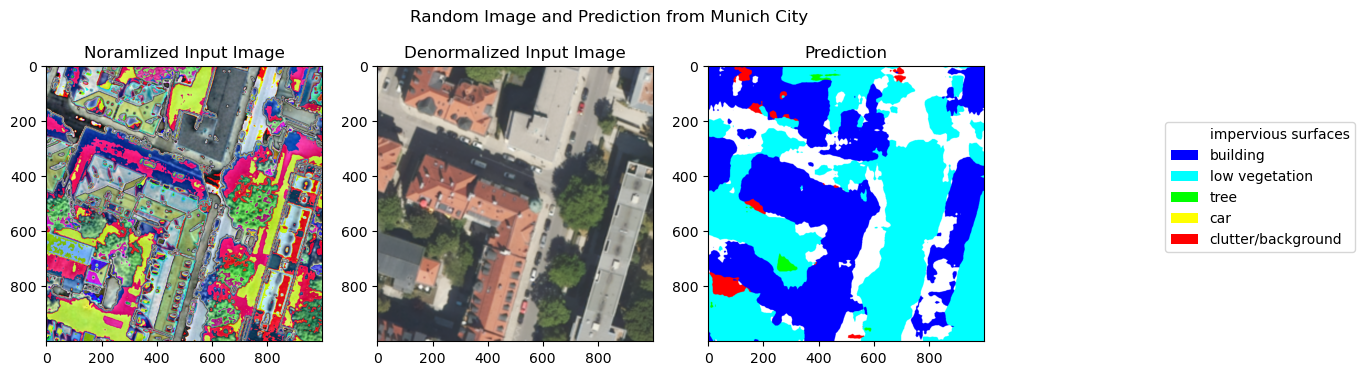

In [10]:
# Plot random instance of the test set
idx = random.randint(0, all_images.shape[0]-1)
img = all_images[idx,:,:,:]
prediction = all_predictions[idx, :, :]

fig, ax = plt.subplots(1,3, figsize = (15,4))
ax[0].imshow(ToPILImage()(torch.from_numpy(img)))
ax[0].set_title('Noramlized Input Image')
ax[1].imshow(ToPILImage()(torch.from_numpy(denormalize_image(img))))
ax[1].set_title('Denormalized Input Image')
ax[2].imshow(map_label2rgb(prediction))
ax[2].set_title('Prediction')
plt.suptitle('Random Image and Prediction from Munich City')

colors = [(r / 255, g / 255, b / 255, 1) for r, g, b in idx2rgb.values()]
labels = [str(idx2label[key]) for key in idx2rgb]

# Create a legend using the extracted colors and labels
patches = [plt.Rectangle((0, 0), 1, 1, fc=color) for color in colors]
fig.legend(patches, labels, loc=7)
fig.subplots_adjust(right=0.75)

plt.show()